### Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Library install & Version Confirm

In [2]:
!pip install albumentations==1.1.0
!pip install "opencv-python-headless<4.3"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 5.8 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 87.6 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [3]:
import albumentations as A
print(A.__version__)#1.1.0

1.1.0


### Transform Define
https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [ ]:
from albumentations.augmentations.transforms import Sharpen
import albumentations as A
import random
random.seed(1013)

train_transform = A.Compose([ 
                              A.Sharpen(alpha=(0.2, 0.2), lightness=(0.5, 0.5), p=1),
                              A.HorizontalFlip(p=0.5),
                              A.RandomBrightness(limit=[0.2 ,0.2], p=0.3),                       
                               ], bbox_params=A.BboxParams(format='yolo'))

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


### Data Load

In [ ]:
import glob
import os

img_lst = glob.glob("/content/drive/MyDrive/Colab_Notebooks/안벽/data_label_추가본/"+"*.jpg")+glob.glob("/content/drive/MyDrive/Colab_Notebooks/안벽/data_label_추가본/"+"*.JPG")
bbox_lst = glob.glob("/content/drive/MyDrive/Colab_Notebooks/안벽/data_label_추가본/"+"*.txt")

img_lst.sort()
bbox_lst.sort()

len(img_lst), len(bbox_lst)

(156, 156)

### Function Define

In [ ]:
import cv2
import numpy as np

def image_bbox_transform_ver_yolo(img_item, bbox_item, transfrom_version):
  im = cv2.imread(img_item)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) #image

  bbox = np.loadtxt(fname=bbox_item,delimiter=" ",ndmin=2)
  bbox = np.roll(bbox,4,axis=1).tolist() # x,y,w,h,class 순서로 변경

  transformed = transfrom_version(image=im, bboxes=bbox) 
  transformed_image = transformed['image']
  transformed_bboxes = transformed['bboxes']
  
  return transformed_image,transformed_bboxes

### Image Data Preprocessing & Save

In [ ]:
import os

def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [ ]:
from tqdm import tqdm

sample_preds_folder = "/content/drive/MyDrive/Colab_Notebooks/안벽/Prototype_v2/"
dir_img = "random_img/"
dir_bbox = "random_bbox/"

In [ ]:
# Create Directory

createDirectory(sample_preds_folder+dir_img)
createDirectory(sample_preds_folder+dir_bbox)

In [ ]:
def coor_save(bbox):
  bbox_st = ', '.join(map(str, bbox))
  bbox_st = bbox_st.split(", ")
  bbox_st = list(map(float, bbox_st))
  bbox_st[0] = int(bbox_st[0])
  bbox_st = ' '.join(map(str, bbox_st))
  return bbox_st

In [ ]:
# 증강
for img_item, bbox_item in tqdm(zip(img_lst,bbox_lst)):

    transformed_image,transformed_bboxes = image_bbox_transform_ver_yolo(img_item, bbox_item,train_transform) 

    cv2.imwrite(os.path.join(sample_preds_folder,dir_img,"{}{}.jpg".format(img_item[65:-4],"_aug")),transformed_image) # 새로운 이미지 저장
    
    f_name = os.path.join(sample_preds_folder,dir_bbox,"{}{}.txt".format(bbox_item[65:-4],"_aug"))
    
    with open(f_name, 'w') as f:
      if len(transformed_bboxes) >= 2:       # image에 object가 2개 이상 있는 경우 
        for i in range(len(transformed_bboxes)):
          coor = transformed_bboxes[i]
          bbox = np.roll(coor,1)             # class가 맨 앞으로 오도록 변경
          bbox_st = coor_save(bbox)
          f.write(bbox_st+"\n")

      else:                                  # image에 object가 하나만 있는 경우
        bbox = np.roll(transformed_bboxes[0],1) # class가 맨 앞으로 오도록 변경
        bbox_st = coor_save(bbox)
        f.write(bbox_st+"\n")
 

156it [01:30,  1.72it/s]


----------------------------------------------------------------

### Preprocessing Validation
- 실제로 라이브러리가 잘 증강 시켜주는지, 바운딩 박스와의 오차는 없는지 확인

225 3626 464 1109


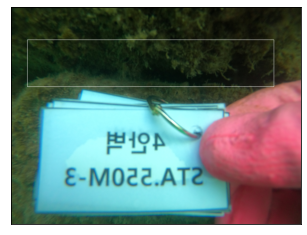

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

image = plt.imread('/content/drive/MyDrive/Colab_Notebooks/안벽/data_label_추가본/GOPR2891(크랙).JPG')
bbox = np.loadtxt(fname="/content/drive/MyDrive/Colab_Notebooks/안벽/data_label_추가본/GOPR2891(크랙).txt",delimiter=" ",ndmin=2)
bbox = np.roll(bbox,4,axis=1).tolist()

transform = A.Compose([
    A.HorizontalFlip(p=1),
], bbox_params=A.BboxParams(format='yolo'))

transformed = transform(image=image, bboxes=bbox)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']

w = np.shape(transformed_image)[1]
h = np.shape(transformed_image)[0]

plt.imshow(transformed_image)
for i in transformed_bboxes:
    x1 = int((i[0] - i[2]/2)*w)
    x2 = int((i[0] + i[2]/2)*w)
    y1 = int((i[1] - i[3]/2)*h)
    y2 = int((i[1] + i[3]/2)*h)
    print(x1,x2,y1,y2)
    cv2.rectangle(transformed_image, (x1, y1), (x2, y2), (255, 255, 255), 3)

plt.xticks([]); plt.yticks([])
plt.imshow(transformed_image)